# Settings

In [72]:
import os
import cv2
import glob
import random
import numpy as np
from time import time
from matplotlib import pyplot as plt

from collections import defaultdict

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, TensorBoard, Callback

# Prepare data

In [73]:
def pad_data(patches):
    """Pads images that are smaller than 50x50 with zeros. Saves images in a new folder."""
    WIDTH = 50
    HEIGHT = 50
    for img_name in patches:
        image = cv2.imread(img_name)
        orig_height, orig_width, _ = image.shape
        patient = img_name.split('/')[2]
        path = "padded/" + patient
        os.makedirs(path, exist_ok=True)
        if (orig_height != 50 or orig_width != 50):
            height_diff = HEIGHT - orig_height
            width_diff = WIDTH - orig_width
            top = height_diff // 2 # floor division
            bottom = height_diff - top
            left = width_diff // 2
            right = width_diff - left
            constant = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
            cv2.imwrite(os.path.join(path, img_name.split('/')[4]), constant)
        else:
            cv2.imwrite(os.path.join(path, img_name.split('/')[4]), image)
            
patches = glob.glob('./data/**/*.png', recursive=True)

if not os.path.isdir("padded"):
    pad_data(patches)

In [74]:
def filter_patients(patients_list, ratio=0.1):
    """Divides data into 2 sets with the given ratio. Each set contains different patients' data."""
    # sample ID numbers for test set
    amount = round(len(patients_list)*ratio)
    test_patients = np.random.choice(patients_list, amount, replace=False)

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    # divide data into training and test sets according to sampled set
    patches = glob.glob("./padded/**/*.png")
    for img_name in patches:
        image = cv2.imread(img_name)
        patient_id = int(img_name.split('/')[2])
        if patient_id not in test_patients:
            X_train.append(image)
            y_train.append(0) if img_name.endswith('class0.png') else y_train.append(1)
        else:
            X_test.append(image)
            y_test.append(0) if img_name.endswith('class0.png') else y_test.append(1)
    
    return np.array(X_train), np.array(X_test), y_train, y_test, test_patients

In [75]:
def split_data_patients():
    """Splits data into training, tuning and testing set."""
    subfolders = glob.glob("./padded/*")
    patients = []
    for s in subfolders:
        patients.append(int(s[9:]))
    sorted_patients = sorted(patients)

    X_train, X_test, y_train, y_test, unseen = filter_patients(sorted_patients, 0.1)
    remaining_ps = [p for p in sorted_patients if p not in unseen]
    X_train, X_tune, y_train, y_tune, _ = filter_patients(remaining_ps, 0.1)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

In [76]:
def load_and_split_data():
    """Loads data from disk and splits into training, tuning and testing set."""
    patches = glob.glob('./padded/*.png')
    X = []
    y = []

    for img_name in patches:
        image = cv2.imread(img_name)
        X.append(image)
        y.append(0) if img_name.endswith('class0.png') else y.append(1)

    X = np.array(X)
    y = np.array(y)
    
    # splitting data into training, validation and test set via indices
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    train_idx, test_idx = list(splitter.split(X, y))[0]
    train_idx, tune_idx = list(splitter.split(X[train_idx], y[train_idx]))[0]
    
    return X[train_idx], X[tune_idx], X[test_idx], y[train_idx], y[tune_idx], y[test_idx]

In [77]:
def prepare_data():
    """Zero centers and normalizes data between -1 and 1. One-hot encodes label vectors."""
    # X_train, X_tune, X_test, y_train, y_tune, y_test = load_and_split_data()
    X_train, X_tune, X_test, y_train, y_tune, y_test = split_data_patients()
    
    # calculate per channel 'mean image' (average pixel values) from training data
    mean_image = np.mean(X_train, axis = 0)  # shape=(50, 50, 3)
    
    # creating zero-centered datasets
    X_train = X_train - mean_image
    X_tune = X_tune - mean_image
    X_test = X_test - mean_image
    
    # normalize between -1 and 1
    X_train = 2 * (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train)) - 1
    X_tune = 2 * (X_tune - np.min(X_tune))/(np.max(X_tune) - np.min(X_tune)) - 1
    X_test = 2 * (X_test - np.min(X_test))/(np.max(X_test) - np.min(X_test)) - 1
    
    # one-hot encoding labels
    y_train = np_utils.to_categorical(y_train, 2)
    y_tune = np_utils.to_categorical(y_tune, 2)
    y_test = np_utils.to_categorical(y_test, 2)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

In [78]:
def balance(X, y, ratio=0.5):
    """ Function for getting balanced data set.
        Ratio in favour of negative examples.
    """
    X0 = []
    X1 = []
    
    pos = (y[:,1]==1).sum()
    neg = (y[:,0]==1).sum()
    y = np.argmax(y, axis=1) 
    
    for i in range(0, len(y)):
        X1.append(X[i]) if y[i] == 1 else X0.append(X[i]) 
    X0 = np.array(X0)
    X1 = np.array(X1)
    
    neg_size = int(len(X1)*ratio/(1-ratio))
    
    X0 = X0[:neg_size]
    X_balanced = np.concatenate((X0, X1))

    a = [0] * len(X0) 
    b = [1] * len(X1)
    y_balanced = a + b
    y_balanced = np_utils.to_categorical(y_balanced, 2)

    return X_balanced, y_balanced  

# Load and analyze data

In [79]:
X_train, X_tune, X_test, y_train, y_tune, y_test = prepare_data()

In [80]:
def analyze_data(X, y, name):
    """Prints information about the dataset."""
    pos = (y[:,1]==1).sum()
    neg = (y[:,0]==1).sum()
    print("{} set has {} ({:.3}%) positive and {} ({:.3}%) negative examples.".format(name, pos, pos/(pos+neg)*100.0, neg, neg/(pos+neg)*100.0))
    print("> shape={}, range=[{}, {}]".format(X.shape, np.min(X), np.max(X)), end='\n\n')

analyze_data(X_train, y_train, "Training")
analyze_data(X_tune, y_tune, "Validation")
analyze_data(X_test, y_test, "Test")

Training set has 73217 (28.3%) positive and 185415 (71.7%) negative examples.
> shape=(258632, 50, 50, 3), range=[-1.0, 1.0]

Validation set has 5569 (29.5%) positive and 13323 (70.5%) negative examples.
> shape=(18892, 50, 50, 3), range=[-1.0, 1.0]

Test set has 6566 (23.3%) positive and 21625 (76.7%) negative examples.
> shape=(28191, 50, 50, 3), range=[-1.0, 1.0]



# Build Models

In [6]:
def create_MLP():
    """Creates a simple fully connected network to compute a baseline."""
    input_shape = (50, 50, 3)
    num_classes = 2
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [7]:
baseline = create_MLP()
baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              7681024   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 8,732,674
Trainable params: 8,732,674
Non-trainable params: 0
_________________________________________________________________


In [8]:
def create_CNN(lmbd, p_dropout):
    """Builds Keras model using a CNN architecture."""
    input_shape = (50, 50, 3)
    num_classes = 2
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal'))              #50x50
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), padding='valid', kernel_initializer='he_normal'))             #46x46
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))                                       #23x23
    model.add(Dropout(p_dropout))
    
    model.add(Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_normal'))             #21x21
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='valid', strides=2, kernel_initializer='he_normal'))  #10x10
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))                                       #5x5
    model.add(Dropout(p_dropout))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(lmbd)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(p_dropout))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
cnn = create_CNN(lmbd=0.0001, p_dropout=0.2)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 50, 50, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 46, 46, 32)        128       
__________

# Hyperparameter tuning

In [ ]:
def sample_models():
    """Runs model with sampled hyperparameters and returns dictionary with accuracies."""
    print("Finding best model in 15 epochs...")
    model_params = {}
    for lmbd in [0.1, 0.01, 0.001, 0.0001]:                   # grid search
        for batch_size in [32, 64, 128, 256]:                 # grid search
            for i in range(0, 4):
                dropout = round(random.uniform(0.1, 0.9), 1)  # random search
                cnn_pad = create_CNN(lmbd=lmbd, p_dropout=dropout)
                fit_history = cnn_pad.fit(X_train, y_train, batch_size=batch_size, epochs=15,
                              shuffle=True, verbose=0, validation_data=(X_tune, y_tune))
                acc = cnn_pad.evaluate(X_tune, y_tune, verbose=0)[1]
                print("Acc: {:.3} with lambda={}, batch_size={}, dropout={}".format(acc, lmbd, batch_size, dropout))
                model_params[(lmbd, batch_size, dropout)] = acc
    print("Done!")
    return model_params

model_params = sample_models()

# Train and evaluate the final models

In [ ]:
class MetricsCallback(Callback):
    """Class for creating a callback which will compute F1 score and roc_auc_score
       at the end of each epoch using the whole validation data."""
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.aucs = []
        
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).round()
        target = self.validation_data[1]
        val_f1 = f1_score(target, predict, average='micro')
        val_auc= roc_auc_score(target, predict)
        logs['val_auc'] = val_auc
        logs['val_f1'] = val_f1
        self.f1s.append(val_f1)
        self.aucs.append(val_auc)
        return

In [10]:
epochs = 30
batch_size = 64

mlp_history = baseline.fit(X_train, y_train, epochs=epochs, 
                           batch_size=batch_size, shuffle=True, verbose=1, validation_data=(X_tune, y_tune))

Train on 224793 samples, validate on 24978 samples
Epoch 1/30
224793/224793 [==============================] - 349s 2ms/step - loss: 0.4488 - acc: 0.8109 - val_loss: 0.4017 - val_acc: 0.8242
Epoch 2/30
224793/224793 [==============================] - 216s 963us/step - loss: 0.4130 - acc: 0.8230 - val_loss: 0.4275 - val_acc: 0.8191
Epoch 3/30
224793/224793 [==============================] - 105s 467us/step - loss: 0.4076 - acc: 0.8282 - val_loss: 0.4056 - val_acc: 0.8292
Epoch 4/30
224793/224793 [==============================] - 128s 570us/step - loss: 0.3993 - acc: 0.8332 - val_loss: 0.4307 - val_acc: 0.8200
Epoch 5/30
224793/224793 [==============================] - 159s 708us/step - loss: 0.3905 - acc: 0.8378 - val_loss: 0.4733 - val_acc: 0.8263
Epoch 6/30
224793/224793 [==============================] - 95s 422us/step - loss: 0.3842 - acc: 0.8410 - val_loss: 0.4405 - val_acc: 0.8099
Epoch 7/30
224793/224793 [==============================] - 94s 417us/step - loss: 0.3788 - acc: 0.8

In [11]:
epochs = 30
batch_size = 64

# Define Keras callbacks
#metrics = MetricsCallback()
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}{}".format(time(),'_centered_split_norm_new_arch'), histogram_freq=1, 
                          batch_size=batch_size, write_grads=True, write_images=False)

# Train model
fit_history = cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                      shuffle=True, verbose=1, validation_data=(X_tune, y_tune),
                      callbacks=[tensorboard])#, metrics, early_stopping])

Train on 224793 samples, validate on 24978 samples
Epoch 1/30
224793/224793 [==============================] - 559s 2ms/step - loss: 0.4129 - acc: 0.8476 - val_loss: 0.3372 - val_acc: 0.8680
Epoch 2/30
224793/224793 [==============================] - 427s 2ms/step - loss: 0.3327 - acc: 0.8668 - val_loss: 0.3292 - val_acc: 0.8687
Epoch 3/30
224793/224793 [==============================] - 404s 2ms/step - loss: 0.3110 - acc: 0.8743 - val_loss: 0.3150 - val_acc: 0.8737
Epoch 4/30
224793/224793 [==============================] - 403s 2ms/step - loss: 0.3016 - acc: 0.8788 - val_loss: 0.3100 - val_acc: 0.8795
Epoch 5/30
224793/224793 [==============================] - 431s 2ms/step - loss: 0.2931 - acc: 0.8834 - val_loss: 0.2956 - val_acc: 0.8807
Epoch 6/30
224793/224793 [==============================] - 401s 2ms/step - loss: 0.2860 - acc: 0.8865 - val_loss: 0.2842 - val_acc: 0.8879
Epoch 7/30
224793/224793 [==============================] - 403s 2ms/step - loss: 0.2785 - acc: 0.8888 - val_

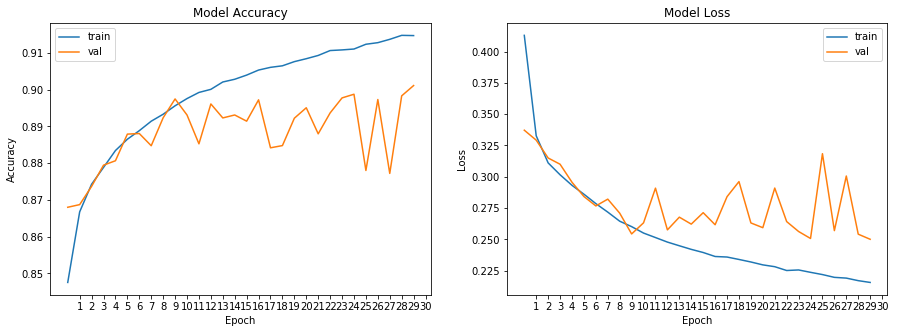

In [12]:
def plot_history(history):
    """Utility function for plotting the model's accuracy and loss."""
    
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_xticks(np.arange(1, len(history.history['acc'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_xticks(np.arange(1, len(history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_history(fit_history)

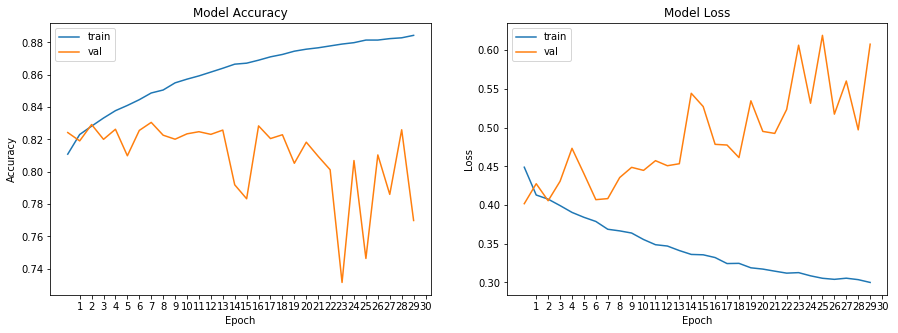

In [13]:
plot_history(mlp_history)

# Evaluate performance on test set

In [14]:
def get_metrics(model, X, y):
    """Returns F1 score, false and true positive rate and ROC area under curve."""
    y_pred = model.predict(X)  # softmax probabilities (each prediction has two entries)
    y_prob = y_pred[:,1]       # probabilities of postitve class
    y = np.argmax(y, axis=1)   # remove one-hot encoding
    
    fpr, tpr, _ = roc_curve(y, y_prob)  
    auc = roc_auc_score(y, y_prob)
    f1 = f1_score(y, np.argmax(y_pred, axis=1), average='micro')
    
    return f1, fpr, tpr, auc

def plot_roc_curve(fpr, tpr, auc, dataset):
    """Given the false and true positive rate, as well as the area under curve,
    this function plots the ROC curve for a given dataset."""
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = {:.2}'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic on {} set'.format(dataset))
    plt.legend(loc="lower right")
    plt.show()

Evaluating test set...
loss: 0.21 - acc: 0.916 - f1 score: 0.916


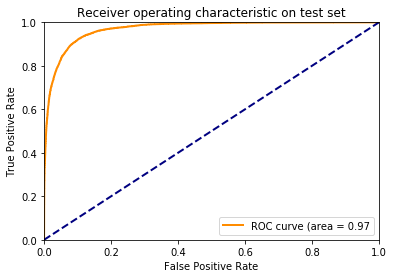

In [15]:
score = cnn.evaluate(X_test, y_test, verbose=0)
f1, fpr, tpr, auc = get_metrics(X_test, y_test)

print("Evaluating test set with CNN...")
print("loss: {:.3} - acc: {:.3} - f1 score: {:.3}".format(score[0], score[1], f1))
plot_roc_curve(fpr, tpr, auc, 'test')

Evaluating test set with MLP...
loss: 0.438 - acc: 0.818 - f1 score: 0.818


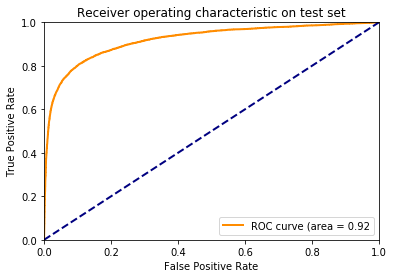

In [16]:
score_mlp = baseline.evaluate(X_test, y_test, verbose=0)
f1, fpr, tpr, auc = get_metrics(baseline, X_test, y_test)

print("Evaluating test set with MLP...")
print("loss: {:.3} - acc: {:.3} - f1 score: {:.3}".format(score_mlp[0], score_mlp[1], f1))
plot_roc_curve(fpr, tpr, auc, 'test')